In [2]:
#importing libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('default')

df = pd.read_csv("/datc/opschaler/combined_gas_smart_weather_dfs/processed/P01S01W8655_hour.csv",header=0,delimiter="\t",parse_dates = ['datetime'])
df = df.set_index(['datetime'])

In [3]:
df.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,RG,SQ,T,T10,TD,U,VV,WW,dwelling,gasPower
datetime,,,,,,,,,,,,,,,,,,,,,
2017-04-24 12:00:00,778.058,0.0,736.961,0.0,153.76537,0.0,1591.658,255.05000,44.0,7.056667,...,0.0,1.276400,12.450000,13.983334,7.000000,68.833336,29966.666,10.833333,P01S01W8655,NaN
2017-04-24 13:00:00,778.207,0.0,736.961,0.0,148.48604,0.0,1591.658,252.86667,58.0,6.928333,...,0.0,0.513033,12.766666,13.850000,6.533333,65.333336,36050.000,32.666668,P01S01W8655,0.0
2017-04-24 14:00:00,778.418,0.0,736.961,0.0,214.16338,0.0,1591.658,259.85000,0.0,7.096667,...,0.0,1.507850,12.800000,14.266666,6.483334,65.000000,40366.668,5.500000,P01S01W8655,0.0
2017-04-24 15:00:00,778.570,0.0,736.961,0.0,151.11765,0.0,1591.658,263.51666,0.0,6.660000,...,0.0,0.000000,12.400000,13.633333,6.600000,67.333336,34000.000,2.000000,P01S01W8655,0.0
2017-04-24 16:00:00,778.750,0.0,736.961,0.0,180.75978,0.0,1591.658,252.88333,0.0,6.373334,...,0.0,0.130250,12.150000,13.033333,6.416666,67.333336,35150.000,2.000000,P01S01W8655,0.0


In [8]:
#Resampling the imported data to a specified resolution (line 3) to train on different time frames. 

sample_rate = '1d' #Sets the resolution of the data using downsampling.Can be 1h, 3h, 1d, 7d etc. 
def resample_df(df,sample_rate):
    
    input_df = df
    to_last = ['gasMeter','eMeter']
    input_df[to_last] = input_df[to_last].resample(sample_rate).last()
    input_df = input_df.resample(sample_rate).mean()
    
    return(input_df)

rdf=resample_df(df,sample_rate) #downsamples data from hourly resolution to specified resolution in line 3. 

rdftrain = rdf[:]
rdftrain = rdftrain[rdftrain['T'] < 16.5] #Only uses data with T < 16.5 for training MVLR due to homes not heating when T>16.5. 

bias = rdf[rdf['T'] > 16.5] #defines a bias for temperatures above 16.5 Degrees 
bias = bias['gasPower'].mean() #takes the average of gasPower when T > 16.5
print(bias)

0.01197026215270452


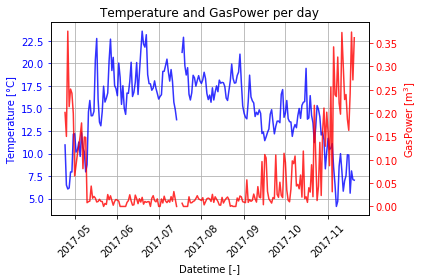

In [5]:
#Visualization of gasPower and Temperature at different datetimes. This shows the correlation between outside temperature and gasPower.

fig, ax1 = plt.subplots() 
ax1.plot(rdf.index[:],rdf['T'][:], '-', color='b', ms=10, alpha=0.8)
plt.title('Temperature and GasPower per day')
ax1.set_xlabel('Datetime [-]')
plt.xticks(rotation=45)
#Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('Temperature [°C]', color='b')
ax1.tick_params('y', colors='b')
plt.grid()
fig.tight_layout()

ax2 = ax1.twinx()
ax2.plot(rdf.index[:],rdf['gasPower'][:], '-', color='r', ms=10, alpha=0.8)
ax2.set_ylabel('GasPower [m$^3$]', color='r')
ax2.tick_params('y', colors='r')
fig.tight_layout()

#plt.savefig('sample1d.png', dpi=1000)
plt.show()

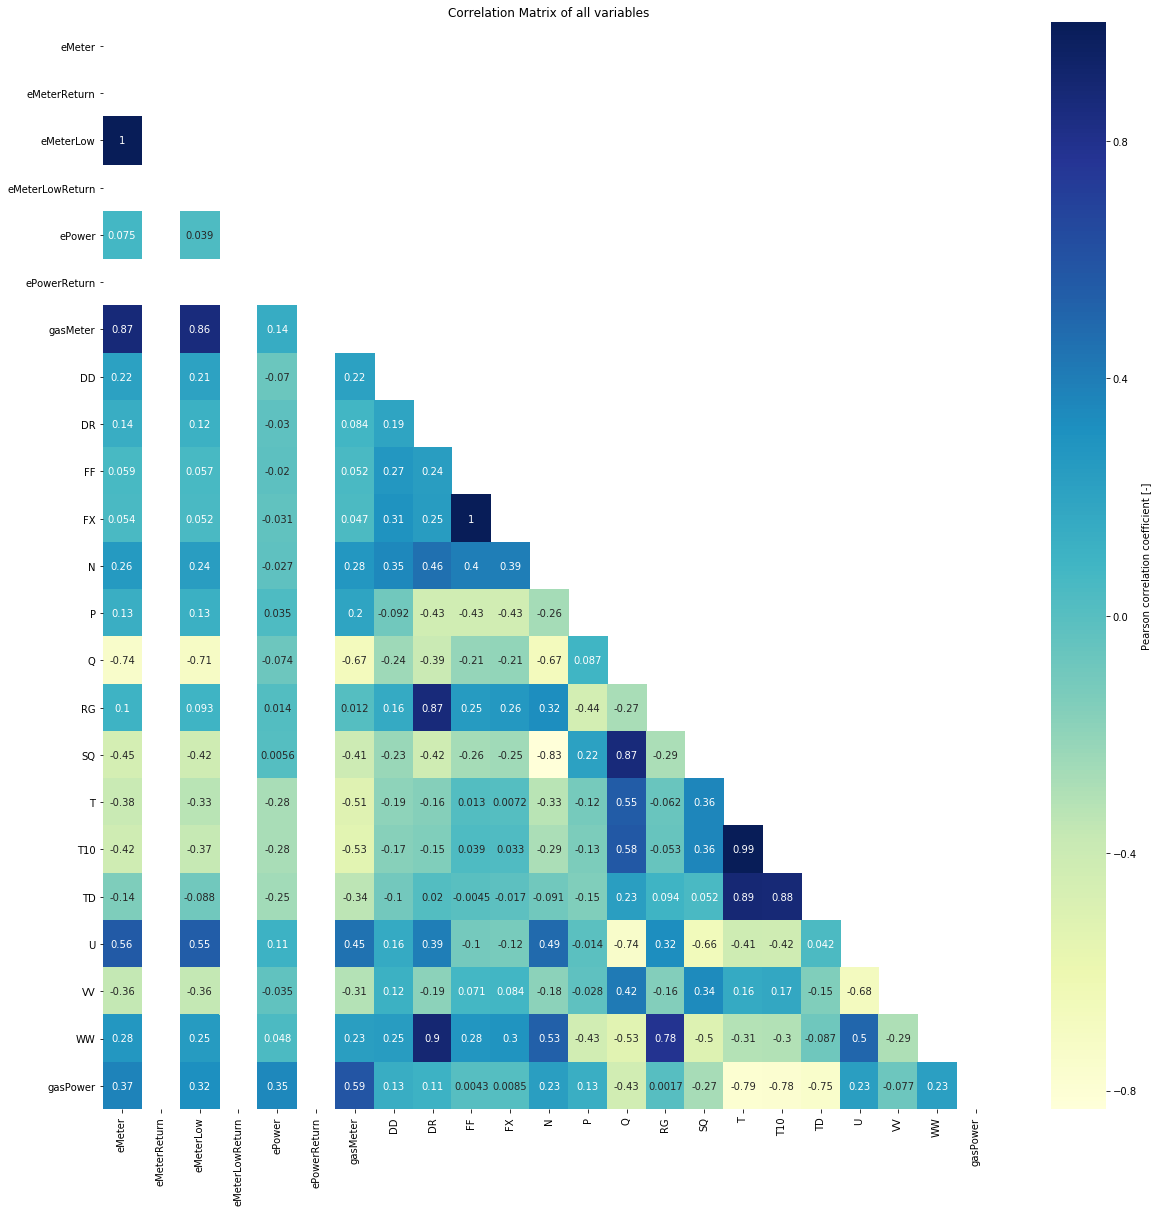

In [6]:
#Correlation matrix of all variables in the dataset. The dataset is currently downsampled to a 1 day resolution. 
#Dark blue is highly correlated, light yellow is highly inversely correlated
corr = rdf.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(corr, mask=mask, square=False, cmap='YlGnBu', annot=True, ax=ax,
             cbar_kws={'label':'Pearson correlation coefficient [-]'})

plt.title('Correlation Matrix of all variables')
plt.xticks(rotation=90)
#plt.savefig('correlations.png', dpi=1000)
plt.show()

[-0.02721326  0.43331924]


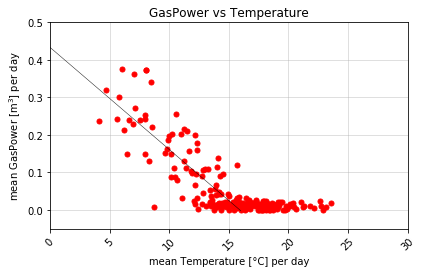

In [7]:
#Visualization of consumed gasPower at different outside temperatures. The linear regression shows correlation between the two variables. 

plt.title('GasPower vs Temperature')

plt.plot(rdf['T'][:],rdf['gasPower'][:], '.', color='r', ms=10)
plt.ylabel('mean GasPower [m$^3$] per day')
plt.xlabel('mean Temperature [°C] per day')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.tight_layout()

# Simple linear regression on gasPower vs Temperature. The fitted data is gasPower with T < 16.5 degrees Celcius. 
params = np.polyfit(rdftrain['T'],rdftrain['gasPower'], 1) #Least squares polynomial fit from Numpy library
def model(x, a, b):
    return a * x + b

# Extrapolations
x = np.array([-10,16])
plt.plot(x, model(x, *params), 'k', alpha=0.9, linewidth=0.5)

plt.xlim(0,30)
plt.ylim(-0.05, 0.5)

plt.savefig('gasvstemp1d.png', dpi=700)
print(params) #prints the parameters of the linear regression